In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class DataManager:
    def __init__(self):
        self.feature = None
        self.rdf = None # raw df
        self.data = None # dictionary of processed dfs data
        self.X = None
        self.y = None
        self.tdata = None
        
    def read_training_data(self, file_name):
        df = pd.read_csv(file_name, encoding='big5', na_values=['NR'])
        df = df.fillna(0.0)
        df = df.rename(columns={
            df.columns[0]: 'date',
            df.columns[1]: 'location',
            df.columns[2]: 'feature'
        })
        df.date = pd.to_datetime(df.date)
        df = df.drop(columns=['location'])
        self.feature = sorted(df.feature.unique())
        self.rdf = df
        self.rdf_to_data()
        return 
    
    def preprocess_mdfs(self, mdfs):
        for m, df in mdfs.items():
#             nrows, ncols = df. shape
            cols = df.columns
#             mask = np.zeros((nrows, 1), dtype=bool)
            for col in cols:
                df = df[df[col] > 0.0]
#                 print(df)
            
            mdfs[m] = df
            
        return mdfs
    
    def rdf_to_data(self):
        rdf = self.rdf
        data = {month: {feature: df.drop(columns=['date', 'feature']).values.flatten() for feature, df in mdf.groupby(mdf.feature)} for month, mdf in rdf.groupby(rdf.date.dt.month)}
        self.data = data
        return 
    
    def select_feature_to_mdfs(self, feature_list=None):
        if feature_list is None:
            feature_list = self.feature
#         mdfs = {month: pd.DataFrame(columns=feature_list) for month in range(1, 13)}
        mdfs = {month: pd.DataFrame(columns=sorted(feature_list)) for month in range(1, 13)}

        for month, fdata in self.data.items():
            for feature in feature_list:
                mdfs[month][feature] = fdata[feature]
            
        return mdfs
    
    
    def chunk_examples(self, mdfs, chunk_size):
        X = []
        y = []
        for month, mdf in mdfs.items():
            nrows, ncols = mdf.shape

            for i in range(nrows-chunk_size):
#                 X.append(mdf.iloc[i:i+chunk_size].T.values.flatten())
#                 print(mdf)
                X.append(mdf.iloc[i:i+chunk_size].values.flatten())
                y.append(mdf['PM2.5'].iloc[i+chunk_size])
#                 print(mdf.iloc[i:i+chunk_size], mdf['PM2.5'].iloc[i+chunk_size])
                
        self.X = np.array(X)
        self.y = np.array(y).reshape((-1, 1))
        return self.X, self.y
    
    def get_shuffle_index(self):
        m, n = self.X.shape
        idx = np.random.permutation(np.arange(m))
        return idx
    
    def read_testing_data(self, file_name):
        df = pd.read_csv(file_name, header=None, na_values=['NR'])
        df = df.rename(columns={0: 'id', 1: 'feature'})
        df = df.fillna(0.0)
        self.tdata = df
        return
    
    def select_testing_feature(self, feature_list=None):
        if feature_list is None:
            feature_list = self.feature
            
        iddfs = {i: df for i, df in self.tdata.groupby(self.tdata.id)}
        
        for i, df in iddfs.items():
            columns = df.feature
            df = df.drop(columns=['id', 'feature']).T
            df.columns = columns
            df = df[sorted(feature_list)]
            iddfs[i] = df
        return iddfs


In [3]:
def normalize_data(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_n = (X - mu) / sigma
    return X_n, mu, sigma

In [4]:
def norm_eq(X, y):
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), y)
    return theta

In [5]:
def predict(theta, instance):
    h_theta = np.dot(instance, theta)
    return h_theta

In [6]:
def h(X, theta):
    return np.dot(X, theta)

In [7]:
def J(theta, h, X, y):
    m, n = X.shape
    square_error = np.sum((h(X, theta) - y)**2)
    return (1 / 2) * (1 / m) * square_error

In [8]:
def gradient_descent(theta, h, X, y, eta, n_iters):
    m, n = X.shape
    theta_record = np.zeros((n_iters, *theta.shape))
    loss_record = np.zeros((n_iters, 1))
    
    theta_record[0] = theta
    loss_record[0] = J(theta, h, X, y)
    grad_square_sum = np.zeros(theta.shape)
    for i in range(1, n_iters):
        grad = (1 / m) * np.dot(X.T, (h(X, theta) - y))
        
        grad_square_sum = grad**2 + grad_square_sum
        
        theta = theta - eta * grad / np.sqrt(grad_square_sum)
        theta_record[i] = theta
        loss_record[i] = J(theta, h, X, y)
        
    return theta, theta_record, loss_record

In [9]:
def initialize_theta(X):
    m, n = X.shape
    
    return np.random.normal(loc=0, scale=1, size=(n, 1))

In [10]:
def find_example_error(theta, h, J, X, y):
    error_list = []

    for i, example in enumerate(zip(X, y)):
        xx, yy = example
        xx = xx.reshape((1, -1))
        yy = yy.reshape((1, 1))
        error_list.append((J(theta, h, xx, yy), i, xx, yy))

    return error_list

In [11]:
def validate_data(rate, h, J, X, y):
    norm_theta = norm_eq(X, y)
    error_list = sorted(find_example_error(norm_theta, h, J, X, y), reverse=True)
    to_drop = error_list[0:int(rate*len(error_list))]
    to_drop_idx = [idx for err, idx, xx, yy in to_drop]
    print(error_list[0:3], error_list[100:103])
    return np.delete(X, to_drop_idx, axis=0), np.delete(y, to_drop_idx, axis=0)

In [12]:
def remove_non_positive_data(X, y):
    Xmask = np.all(X > 0, axis=1)
    ymask = np.all(y > 0, axis=1)
    mask = Xmask & ymask
    return X[mask], y[mask]

In [13]:
def remove_strange_data(X, y):
    Xmask = np.all(X < 300, axis=1)
    ymask = np.all(y < 300, axis=1)
    mask = Xmask & ymask
    return X[mask], y[mask]

In [14]:
dm = DataManager()

In [15]:
dm.read_training_data('./train.csv')

In [16]:
mdfs = dm.select_feature_to_mdfs(['PM2.5', 'PM10'])
# mdfs = dm.select_feature_to_mdfs()

In [17]:
# mdfs = dm.preprocess_mdfs(mdfs)
mdfs[1].shape

(480, 2)

In [18]:
X, y = dm.chunk_examples(mdfs, chunk_size=4)

In [19]:
X, y = remove_non_positive_data(X, y)

In [20]:
X, y = remove_strange_data(X, y)

In [21]:
X_n, mu, sigma = normalize_data(X)

In [22]:
X_n = np.insert(X_n, obj=0, values=1, axis=1)

In [23]:
X[np.any(X > 250, axis=1)]
# X_n[0]

array([], shape=(0, 8), dtype=float64)

In [24]:
X_n, y = validate_data(0.1, h, J, X_n, y)
# X, y = validate_data(0.1, h, J, X, y)
X_n.shape

[(2867.174296213811, 2763, array([[ 1.        ,  0.24825567,  0.70364688,  0.54374452, -0.26950319,
         0.70905358, -0.26817051,  0.25495698,  0.11369558]]), array([[ 111.]])), (1945.9010174394466, 1154, array([[ 1.        ,  2.79163479,  1.78672609,  2.79543664,  2.0640285 ,
         2.79835311,  2.06613375,  2.90226972,  2.23339979]]), array([[ 131.]])), (999.78171216954433, 2766, array([[ 1.        ,  0.24825567,  0.10795331, -0.04365342,  4.50609654,
        -0.17236965,  4.72615488, -0.07187175,  4.8966179 ]]), array([[ 35.]]))] [(82.016107724141833, 4820, array([[ 1.        ,  0.63954476,  0.21626123,  1.03324281,  0.92439674,
         1.4272503 ,  1.4147    ,  1.8237349 ,  1.68988589]]), array([[ 71.]])), (81.958121225331666, 4178, array([[ 1.        ,  1.71558978, -0.27112441,  1.65327397, -0.32377137,
         0.93757072, -0.48531509, -0.85626071, -0.64722388]]), array([[ 20.]])), (81.862198826232742, 3270, array([[ 1.        , -0.04521116, -0.48774025, -0.17418629, -0.48

(4811, 9)

In [25]:
norm_theta = norm_eq(X_n, y)

In [26]:
dm.read_testing_data('./test.csv')

In [27]:
# tX = dm.select_testing_feature(['PM2.5', 'PM10'])
tX = dm.select_testing_feature(['PM2.5', 'PM10'])
tX['id_0']#.iloc[-5:, :]


feature,PM10,PM2.5
2,42.0,39.0
3,42.0,43.0
4,35.0,29.0
5,37.0,23.0
6,34.0,25.0
7,41.0,27.0
8,41.0,32.0
9,49.0,26.0
10,51.0,40.0


In [28]:
init_theta = initialize_theta(X_n)
print(init_theta.shape)
theta, theta_record, loss_record = gradient_descent(init_theta, h, X_n, y, eta=0.1, n_iters=200000)
loss_record[-1]

(9, 1)


array([ 6.43353549])

In [29]:
results = []
for i, tdf in tX.items():
    tdf = tdf.iloc[-4:, :]
    instance_n = (tdf.values.flatten() - mu) / sigma
#     instance_n = (tdf.T.values.flatten() - mu) / sigma

#     print(tdf.T.values.flatten())
    results.append((i, predict(norm_theta, np.insert(instance_n.reshape((1, -1)), obj=0, values=1, axis=1))[0, 0]))
results = np.array(results)

In [30]:
theta

array([[ 27.7947965 ],
       [  0.17456341],
       [  6.18684254],
       [ -1.91486555],
       [ -8.57872786],
       [ -2.61899565],
       [  0.56924714],
       [  6.53844295],
       [ 17.72689294]])

In [31]:
norm_theta

array([[ 27.7953739 ],
       [  0.11925737],
       [  6.1954345 ],
       [ -1.78701165],
       [ -8.55366319],
       [ -2.719735  ],
       [  0.48180959],
       [  6.55809111],
       [ 17.7900612 ]])

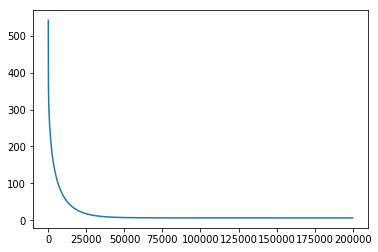

In [32]:
fig, ax = plt.subplots()
ax.plot(np.arange(loss_record.size), loss_record)
# len(loss_record)

In [33]:
J(theta, h, X_n, y)

6.4335354919202086

In [34]:
J(norm_theta, h, X_n, y)

6.4331621360571178

In [35]:
pd.DataFrame(results, columns=['id', 'value']).to_csv('qq.csv', index=False)

In [36]:
pd.DataFrame(results, columns=['id', 'value'])

,id,value
0,id_0,37.7351058106
1,id_1,12.8608750433
2,id_10,27.2346415287
3,id_100,22.6905423123
4,id_101,48.9240418279
5,id_102,30.8970699394
6,id_103,34.734498585
7,id_104,33.8342492692
8,id_105,27.0111490847
9,id_106,15.3893554835


In [37]:
X.shape
# y.shape

(5345, 8)

In [29]:
outliers = dm.find_outlier(norm_theta, h, J, np.insert(X_n, obj=0, values=1, axis=1), y)

In [37]:
so = sorted(outliers, reverse=True)
so[0:100]

[(325362.97543536028,
  1203,
  array([[ 1.        ,  2.75521456,  1.08010122,  2.82490246,  1.00204192,
           2.76713451,  0.97712258,  2.77145596,  0.97881327,  2.77529171,
           0.8727927 ,  2.77813659,  1.00771655,  2.78043533,  1.00817666,
           2.87752186,  1.08933263,  3.10233208,  2.75585438]]),
  array([[ 919.]])),
 (232569.38503011331,
  1208,
  array([[  1.        ,   2.75521456,   0.99984198,   2.76129734,
            1.00204192,   2.86267982,   1.08425955,   3.09027671,
            2.74774469,   3.19023941,  23.88182715,   2.90593536,
           23.89395195,   2.39671709,  23.90216532,   2.10972384,
           -0.76335423,   2.04624265,  -0.76337649]]),
  array([[ 908.]])),
 (198786.98063435667,
  1439,
  array([[ 1.        , -0.61109931, -0.07028127, -0.9914049 , -0.36311179,
          -1.08652648, -0.44244235, -0.83121849, -0.68291018, -0.73580422,
          -0.49487718, -0.60853085, -0.41428869, -0.76895836, -0.25327407,
          -0.51358605, -0.33374568

In [18]:
iddfs = dm.select_testing_feature(['PM2.5', 'PM10'])

In [20]:
iddfs['id_0']

feature,PM10,PM2.5
2,42.0,39.0
3,42.0,43.0
4,35.0,29.0
5,37.0,23.0
6,34.0,25.0
7,41.0,27.0
8,41.0,32.0
9,49.0,26.0
10,51.0,40.0


In [22]:
mdfs[1]

,PM10,PM2.5
0,91.0,58.0
1,104.0,59.0
2,87.0,57.0
3,91.0,59.0
4,83.0,64.0
5,76.0,64.0
6,73.0,60.0
7,66.0,55.0
8,88.0,54.0
9,97.0,61.0


In [60]:
a = np.array([[7.7]])

In [73]:
a.reshape((1,))

array([7.7])

In [75]:
a[0, 0]

7.7

In [20]:
X[147, :]

array([51., 45., 46., 38., 39., 36., 47., 55., 60., 73., 77., 62., 63.,
       70., 79., 93., 87., 96.])

In [98]:
for i in [ 77.,  74.,  69.,  65.,  66.,  75.,  79.,  91.,  92., 116., 112.,97., 107., 112., 127., 133., 122., 122.]:
    print(i in X[100, :])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [18]:
mdfs[1]

,PM2.5,PM10
0,58.0,91.0
1,59.0,104.0
2,57.0,87.0
3,59.0,91.0
4,64.0,83.0
5,64.0,76.0
6,60.0,73.0
7,55.0,66.0
8,54.0,88.0
9,61.0,97.0


In [21]:
y

array([[61.],
       [67.],
       [72.],
       ...,
       [51.],
       [48.],
       [49.]])

In [22]:
norm_theta

array([[28.39755839],
       [-4.45330872],
       [ 2.12965279],
       [-3.32096469],
       [ 2.43711245],
       [ 9.89636874],
       [-1.27055567],
       [-0.03792362],
       [-3.23876269],
       [25.09174963],
       [ 2.41332511],
       [-0.51619257],
       [-1.28303912],
       [ 0.88566275],
       [-1.82602789],
       [-0.25125377],
       [-1.35480615],
       [ 3.62710105],
       [ 3.06946685]])

In [18]:
test_theta = np.array([[28.39755839],
       [-4.45330872],
       [ 2.12965279],
       [-3.32096469],
       [ 2.43711245],
       [ 9.89636874],
       [-1.27055567],
       [-0.03792362],
       [-3.23876269],
       [25.09174963],
       [ 2.41332511],
       [-0.51619257],
       [-1.28303912],
       [ 0.88566275],
       [-1.82602789],
       [-0.25125377],
       [-1.35480615],
       [ 3.62710105],
       [ 3.06946685]]).flatten()

In [21]:
norm_theta

array([[28.39755839],
       [ 2.41332511],
       [-4.45330872],
       [-0.51619257],
       [ 2.12965279],
       [-1.28303912],
       [-3.32096469],
       [ 0.88566275],
       [ 2.43711245],
       [-1.82602789],
       [ 9.89636874],
       [-0.25125377],
       [-1.27055567],
       [-1.35480615],
       [-0.03792362],
       [ 3.62710105],
       [-3.23876269],
       [ 3.06946685],
       [25.09174963]])

In [29]:
a = np.arange(5*9).reshape(5,   9)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26],
       [27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44]])

In [38]:
np.all(a > 0, axis=1)

array([False,  True,  True,  True,  True], dtype=bool)

In [32]:
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23, 24, 25, 26],
       [27, 28, 29, 30, 31, 32, 33, 34, 35],
       [36, 37, 38, 39, 40, 41, 42, 43, 44]])

In [21]:
0.005*5652

28.26